# CE-40717: Machine Learning

## HW7-Regression

### Please fill this part


1.   Full Name: Amirhossein kargaran
2.   Student Number: 99201119

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# You are not allowed to import other packages.

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

### Part1:
Consider the dataset which has been given to you. Split the dataset into the `training dataset` and `test dataset`. You can use `80%` of the data for training and the rest for testing.

In [3]:
dataset = pd.read_csv("./ML2021S-HW7-data.csv")
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.head(5)

,X,Y
0,1.867470,-1.210867
1,1.168675,-0.011459
2,0.795181,-0.882124
3,1.477912,0.006529
4,1.646586,-0.602546


In [5]:
train_csv = dataset[['X']].values
labels = dataset[['Y']].values
# implement the split part
# name them: x_train, x_test, y_train, y_test

split_rate = 0.2
number_of_tests = int(train_csv.shape[0] * split_rate)
indices = np.random.permutation(train_csv.shape[0])
test_idx, train_idx = indices[:number_of_tests], indices[number_of_tests:]

x_train = train_csv[train_idx,:]
y_train = labels[train_idx]

x_test = train_csv[test_idx,:]
y_test = labels[test_idx]

### Part2:
Assume there is simple linear relationship between X and Y. Train a simple `Linear Regression` on the training dataset and report its accuracy on the training and testing dataset, separately.

In [6]:
# here you can implement via sgd or use least square solution. we suggest the second one inv(A^T A) * A^T y.
# consider m as the returned line --> m[0] = the slope , m[1] = y intercept, also don't forget to use numpy for calculating m.

l = x_train.shape[0]
X = np.hstack((x_train, np.ones((l, 1))))
m = np.linalg.inv(X.T@X)@(X.T@y_train)

In [7]:
predicted_train_y = m[0] * x_train + m[1]
predicted_test_y = m[0] * x_test + m[1]

train_error = mean_squared_error(predicted_train_y, y_train, squared=True)
test_error = mean_squared_error(predicted_test_y, y_test, squared=True)


print(f"MSE train error: {train_error}\nMSE test error: {test_error}")

MSE train error: 0.32581071197358624
MSE test error: 0.35108617246909274


### Part3:
Draw the line you've found in the last part, on train and test points (each separately).

Text(0.5, 1.0, 'Train dataset')

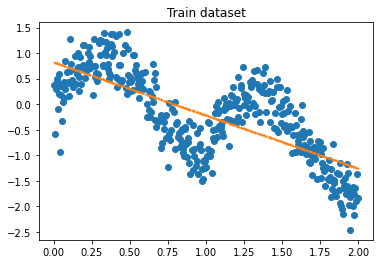

In [8]:
plt.scatter(x_train, y_train)
plt.scatter(x_train, m[0]*x_train + m[1], s=1)
plt.title("Train dataset")

Text(0.5, 1.0, 'Test dataset')

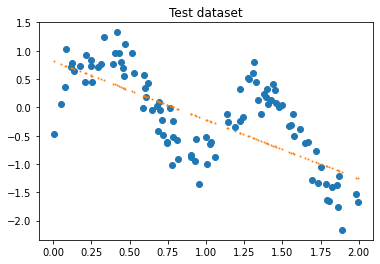

In [9]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, m[0]*x_test + m[1], s=1)
plt.title("Test dataset")

### Part4:
Were the reported accuracies acceptable?

What about the line you drew in the last part?

Was it appropriate for the dataset?
<br><br/>
Explain what are the main problems here.

- a) Train and Test MSE errors (consequently the accuracies) approximately are alike each other. Accuracies are not acceptable for this data but is acceptable compared to the model (without kernel) used. This means that this model is not suitable for this data, Because the data has a wavy form but the predicted model is just a straight line.
- b) A line drawn is like a sloping line with a sinusoidal shape mounted on it. As we saw in class, if we want to suggest a straight line for this data, this is the best bias variance trade-off for a straight line.
- c) No, as mentioned in the section a, it is not suitable for use in this way.

### Part5:
Now, consider the `Locally Weighted Linear Regression` approach for this problem. Do expect it performs better than simple `Linear Regression` for this dataset?

Locally weighted linear regression is a non-parametric algorithm, that means the model does not learn a fixed set of parameters as is done in previous part.
Parameters `\theta` are computed individually for each query point x. In computing `\theta`, a higher `preference` is given to the points in the training set lying in the neighborhood of x than the other points.

### Part6:
Here, we want to implement the `suggested model`. You can implement any weight function you want, the below implementation is just a sample:
<br><br/>
\begin{equation*}
    w^{(i)}=exp\left(-\frac{(\mathbf x^{(i)}-\mathbf x)^\top(\mathbf x^{(i)}-\mathbf x)}{2\tau^2}\right)
\end{equation*}

In [9]:
def get_weight_matrix(the_query_point, train_dataset, hyperparameter):
    l = train_dataset.shape[0]
    W = np.mat(np.eye(l))
    for i, xi in enumerate(train_dataset):
        W[i, i] = np.exp(np.linalg.norm(the_query_point - xi) ** 2 / (-2 * hyperparameter ** 2))
    return W

Now implement the `closed form solution` based on the following formula:
<br><br/>
\begin{equation*}
    \boldsymbol\theta=(X^\top WX)^{-1}(X^\top WY)
\end{equation*}
<br><br/>
Of course if you use another form, implement your own.

In [10]:
def predict(train_X, train_Y, query_x, hyperparameter):
    l = train_X.shape[0]
    X = np.hstack((train_X, np.ones((l, 1))))
    qx = np.mat([query_x, 1])
    W = get_weight_matrix(qx, X, hyperparameter)
    theta = np.linalg.inv(X.T@W@X)@(X.T@W@train_Y)

    return np.dot(qx, theta)

### Part7:
Report accuracy of this model on the test dataset. Also, draw a plot that contains (x_test, y_test) pairs and (x_test, predicted_y) pairs that differ in color.

K-Fold Cross Validation to find `best_hyperparameter`:

In [11]:
n_fold = 5 # number of folds
fold_len = int(x_train.shape[0]/n_fold)

hyperparameter_list = [0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1, 3, 5]

best_hyperparameter = hyperparameter_list[-1]
best_error = np.inf

for hyperparameter in hyperparameter_list:
    error = 0 # error for current k
    for j in range(n_fold):
        temp_error = []
        
        total_index = list(range(fold_len*n_fold))
        val_index = list(range(j*fold_len,(j+1)*fold_len))
        fold_train_index = [x for x in total_index if x not in val_index]

        fold_train_set = x_train[fold_train_index] # the training data for the current fold
        fold_train_target = y_train[fold_train_index] # the training targets for the current fold
        val_set = x_train[val_index] # the validation data for the current fold
        val_target = y_train[val_index] # the validation targets for the current fold

        predicted_test = [predict(fold_train_set, fold_train_target, query, hyperparameter) for query in val_set]
        predicted_test_ = np.array([np.array(i)[0][0] for i in predicted_test])
        error_lwr = mean_squared_error(predicted_test_, val_target, squared = True)

        temp_error.append(error_lwr)


    error = np.mean(temp_error)
    print(f"hyperparameter: {hyperparameter}, error: {error}")
    if error < best_error:
        best_error = error
        best_hyperparameter = hyperparameter

print(f"best hyperparameter: {best_hyperparameter}, error: {best_error}")

hyperparameter: 0.01, error: 0.09167428077025866
hyperparameter: 0.03, error: 0.08392597724356499
hyperparameter: 0.05, error: 0.08336826282841255
hyperparameter: 0.08, error: 0.08530815311465229
hyperparameter: 0.1, error: 0.08809507662095743
hyperparameter: 0.3, error: 0.18787605734238166
hyperparameter: 0.5, error: 0.25403937765099
hyperparameter: 0.8, error: 0.2830626185887075
hyperparameter: 1, error: 0.28770599372476946
hyperparameter: 3, error: 0.2922472506250056
hyperparameter: 5, error: 0.292542833869042
best k: 0.05, error: 0.08336826282841255


In [12]:
hyperparameter = best_hyperparameter
predicted_test = [predict(x_train, y_train, query, hyperparameter) for query in x_test]
predicted_test_ = np.array([np.array(i)[0][0] for i in predicted_test])
error = mean_squared_error(predicted_test_, y_test, squared = True)
print(f"MSE test error: {error}")

MSE test error: 0.11999107785419826


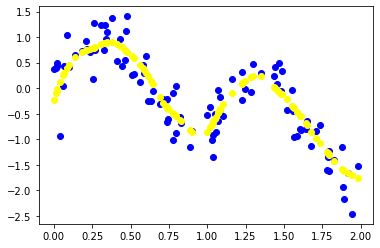

In [13]:
plt.scatter(x_test, y_test, c = "blue")
plt.scatter(x_test, predicted_test, c = "yellow")

### Part8:
Is the performance of the new model better than the previous one? `Explain`.

Locally weighted linear regression is a non-parametric algorithm, that means the model does not learn a fixed set of parameters as is done in previous part.
Parameters `\theta` are computed individually for each query point x. In computing `\theta`, a higher `preference` is given to the points in the training set lying in the neighborhood of x than the other points.

### Part9:
Now, we want to consider the `KNN` approach for this problem; Do you think it will perform well?

Yes, but probably as as good as Locally Weighted Linear Regression.

### Part10:
Implementing the `KNN model`.

In [14]:
class KNN:
    def __init__(self, number_neighbours, X, Y):
        self.k = number_neighbours
        self.X = X
        self.Y = Y

    def distance(self, x1, x2):
        distance = np.sqrt((x1 - x2) ** 2) # implement the distance function
        return distance

    def return_nn_ids(self, x):
        indices = self.distance(self.X, x).argsort(axis = 0)[:self.k] # find indices of k nearest neighbours to x
        return indices

    def predict(self, x):
        neareest_indices = self.return_nn_ids(x)
        predicted_y = self.Y[neareest_indices].mean()
        return predicted_y

In [15]:
def evaluation(k, x_train, y_train, x_test, y_test):
    model = KNN(k, x_train, y_train)
    predicted_y = [model.predict(x) for x in x_test]
    error = mean_squared_error(predicted_y, y_test, squared=True)
    return error, predicted_y

K-Fold Cross Validation to find `k`:

In [17]:
n_fold = 5 # number of folds
fold_len = int(x_train.shape[0]/n_fold)

k_list = range(1, 50)

best_k = k_list[-1]
best_error = np.inf

for k in k_list:
    error = 0 # error for current k
    for j in range(n_fold):
        temp_error = []
        
        total_index = list(range(fold_len*n_fold))
        val_index = list(range(j*fold_len,(j+1)*fold_len))
        fold_train_index = [x for x in total_index if x not in val_index]

        fold_train_set = x_train[fold_train_index] # the training data for the current fold
        fold_train_target = y_train[fold_train_index] # the training targets for the current fold
        val_set = x_train[val_index] # the validation data for the current fold
        val_target = y_train[val_index] # the validation targets for the current fold

        error_knn, predicted_y = evaluation(k, fold_train_set, fold_train_target, val_set, val_target)

        temp_error.append(error_knn)


    error = np.mean(temp_error)
    print(f"k: {k}, error: {error}")
    if error < best_error:
        best_error = error
        best_k = k

print(f"best k: {best_k}, error: {best_error}")

k: 1, error: 0.1710408508160724
k: 2, error: 0.12811810714629476
k: 3, error: 0.09897619178936437
k: 4, error: 0.08909647611012723
k: 5, error: 0.08097035186331442
k: 6, error: 0.08812076577317146
k: 7, error: 0.0876230125085969
k: 8, error: 0.08765600034222214
k: 9, error: 0.0872395235413258
k: 10, error: 0.08432982346096914
k: 11, error: 0.0815135845987401
k: 12, error: 0.08416742647431796
k: 13, error: 0.08575467618285632
k: 14, error: 0.0833075381770394
k: 15, error: 0.08374767310251784
k: 16, error: 0.08225504963516359
k: 17, error: 0.08311504015800056
k: 18, error: 0.08281539766249861
k: 19, error: 0.08352673130022092
k: 20, error: 0.08210443432669397
k: 21, error: 0.08314128129080635
k: 22, error: 0.08448435947363948
k: 23, error: 0.08529413987669834
k: 24, error: 0.0852761351501307
k: 25, error: 0.08412294048605021
k: 26, error: 0.08455676282422511
k: 27, error: 0.0850827308366077
k: 28, error: 0.08228321593117935
k: 29, error: 0.08262511001924133
k: 30, error: 0.08228606924992

In [18]:
k = best_k
error_knn, predicted_y = evaluation(k, x_train, y_train, x_test, y_test)
print(f"MSE error of KNN for test dataset: {error_knn}")

MSE error of KNN for test dataset: 0.1338665884376996


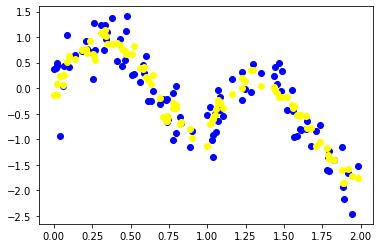

In [19]:
plt.scatter(x_test, y_test, c = "blue")
plt.scatter(x_test, predicted_y, c = "yellow")

To find best K for this algorithm we suggest to use cross-validation.
<br><br/>
Did this model perform well (due to the plot and test accuracy)?

I used cross-validation.
Yes, The test error is low and as we can see, the predicted data follow the test data. In this model each point is classified by a plurality vote of its neighbors. 